In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Inference Metrics: Latency, Throughput, and UX

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/02_performance_metrics.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<p>
<b>Share to:</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/02_performance_metrics.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn logo">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/02_performance_metrics.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky logo">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/02_performance_metrics.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/5a/X_icon_2.svg" alt="X logo">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/02_performance_metrics.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit logo">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/inardini/gcp-nvidia-community-ai-inference-lp/blob/main/learning_path_01/02_performance_metrics.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook logo">
</a>
</p>

## Overview

This notebook is a hands-on introduction to the key performance aspects of running AI inference.

You’ll learn:

- What **latency** and **throughput** mean.
- Why these metrics often trade off against each other.
- How different parameters (like batch size, prompt length, sampling strategy) affect performance.
- How to measure and visualize **p50 vs p90 latency**, **first token (also known as Time to First Token) vs total latency**, and find the "sweet spot".
- What this means for real-world **user experience**.

By the end of this notebook, you'll not only be able to benchmark an AI inference — you'll know what the numbers actually mean and how to tune them for real applications.

## Preliminaries

**Before you begin**, make sure you have:

- An NVIDIA GPU environment
- Your Hugging Face [access token](https://huggingface.co/settings/token)

Let's test which GPUs are available in our system:

In [ ]:
!nvidia-smi

Wed Sep 10 22:44:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:22:00.0 Off |                  Off |
| 30%   48C    P8             29W /  300W |      15MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Authenticating with Hugging Face

In [ ]:
# ⬇️ Run this cell once
from ipywidgets import Password, Button, HBox, Output
import os, pathlib
import sys

from huggingface_hub import HfFolder, whoami

# ---- UI widgets ----
token_box = Password(
    description="HF Token:",
    placeholder="paste your Hugging Face token here",
    layout={"width": "450px"},
)
save_btn = Button(description="Save", button_style="success")
out = Output()

# ---- Callback ----
def save_token(_):
    out.clear_output()
    token = token_box.value.strip()
    with out:
        if not token:
            print("❌ No token entered.")
            return
        # Persist token
        HfFolder.save_token(token)                 # writes to ~/.cache/huggingface/token
        os.environ["HF_TOKEN"] = token             # current kernel env (optional)
        # Sanity-check who we are
        try:
            user = whoami(token)["name"]
            print(f"✅ Token saved. Logged in as: {user}")
        except Exception as e:
            print("⚠️ Token saved, but user lookup failed:", e)

save_btn.on_click(save_token)

display(HBox([token_box, save_btn]), out)

### Loading the model

For the experiments in this tutorial we will be using [nvidia/NVIDIA-Nemotron-Nano-9B-v2](https://huggingface.co/nvidia/NVIDIA-Nemotron-Nano-9B-v2), a large language model (LLM) trained from scratch by NVIDIA, and designed as a unified model for both reasoning and non-reasoning tasks.

In [ ]:
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams
import os

MODEL_ID = "nvidia/NVIDIA-Nemotron-Nano-9B-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

tp = int(os.getenv("TP_SIZE", "1"))  # set >1 if you want tensor parallel across GPUs

llm = LLM(
    model=MODEL_ID,
    dtype="float16",
    trust_remote_code=True,
    tensor_parallel_size=tp,
    max_num_seqs=64,
    max_model_len=131072,
    mamba_ssm_cache_dtype="float32",
)

INFO 09-10 22:44:47 [__init__.py:241] Automatically detected platform cuda.
INFO 09-10 22:44:50 [utils.py:326] non-default args: {'model': 'nvidia/NVIDIA-Nemotron-Nano-9B-v2', 'trust_remote_code': True, 'dtype': 'float16', 'max_model_len': 131072, 'max_num_seqs': 64, 'disable_log_stats': True, 'mamba_ssm_cache_dtype': 'float32'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 09-10 22:45:03 [__init__.py:711] Resolved architecture: NemotronHForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


WARNING 09-10 22:45:03 [__init__.py:2819] Casting torch.bfloat16 to torch.float16.
INFO 09-10 22:45:03 [__init__.py:1750] Using max model len 131072
INFO 09-10 22:45:03 [arg_utils.py:1781] Mamba is experimental on VLLM_USE_V1=1. Falling back to V0 Engine.
WARNING 09-10 22:45:03 [arg_utils.py:1544] Chunked prefill is enabled by default for models with max_model_len > 32K. Chunked prefill might not work with some features or models. If you encounter any issues, please disable by launching with --enable-chunked-prefill=False.
INFO 09-10 22:45:04 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 09-10 22:45:04 [llm_engine.py:222] Initializing a V0 LLM engine (v0.10.1.1) with config: model='nvidia/NVIDIA-Nemotron-Nano-9B-v2', speculative_config=None, tokenizer='nvidia/NVIDIA-Nemotron-Nano-9B-v2', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, ma

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 09-10 22:45:21 [default_loader.py:262] Loading weights took 12.00 seconds
INFO 09-10 22:45:21 [model_runner.py:1112] Model loading took 16.5557 GiB and 12.808316 seconds
INFO 09-10 22:45:30 [worker.py:295] Memory profiling takes 8.06 seconds
INFO 09-10 22:45:30 [worker.py:295] the current vLLM instance can use total_gpu_memory (47.41GiB) x gpu_memory_utilization (0.90) = 42.67GiB
INFO 09-10 22:45:30 [worker.py:295] model weights take 16.56GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 9.44GiB; the rest of the memory reserved for KV Cache is 16.61GiB.
INFO 09-10 22:45:30 [executor_base.py:114] # cuda blocks: 68042, # CPU blocks: 16384
INFO 09-10 22:45:30 [executor_base.py:119] Maximum concurrency for 131072 tokens per request: 8.31x
INFO 09-10 22:45:32 [model_runner.py:1383] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eage

Capturing CUDA graph shapes:   0%|          | 0/11 [00:00<?, ?it/s]

INFO 09-10 22:45:42 [model_runner.py:1535] Graph capturing finished in 9 secs, took 0.14 GiB
INFO 09-10 22:45:42 [llm_engine.py:417] init engine (profile, create kv cache, warmup model) took 20.06 seconds
INFO 09-10 22:45:43 [llm.py:298] Supported_tasks: ['generate']


### Sampling parameters

When generating text, the model can either:

- **Always pick the highest-probability token** (greedy decoding — fast and deterministic).
- **Sample from the probability distribution** over possible next tokens — which adds variety and creativity.

We use the following parameters to control that behavior:

- `temperature = 0.3`: Controls randomness. Lower values → more confident, deterministic outputs. Higher values → more diverse, sometimes erratic responses.
- `top_p = 0.9`: Enables **nucleus sampling** — the model samples only from the top tokens that together make up 90% of the probability mass. Balances diversity and coherence.
- `max_tokens=512`: Controls maximum number of tokens to generate.

When running experiments, you can try changing the prompts and sampling values below to see how the model’s behavior changes!

In [ ]:
sampling = SamplingParams(
    max_tokens=512, temperature=0.3, top_p=0.9
)

### Convertng user prompts to chat

Modern LLMs often use role-tagged messages to structure conversations, where each entry specifies both a role (such as `system`, `user`, or `assistant`) and the `content` of the message. This format helps the model distinguish between instructions, user inputs, and its own prior outputs, enabling more consistent and controllable behavior. The system role typically sets context or constraints (e.g., tone, style, or reasoning mode), the user role provides queries or prompts, and the assistant role represents the model’s responses. By encoding dialogue this way, developers can guide multi-turn interactions, support features like reasoning toggles, and make model behavior easier to align across different applications.

The following helper function will be used to convert a list of role-tagged messages (e.g., system, user) into the exact chat prompt format expected by the **Nemotron Nano 9b v2 model**. It uses the tokenizer’s built-in chat template to render the conversation into text, appends a reasoning marker so the model knows it should reason or not, and outputs the result as a PyTorch tensor ready for inference.

In this fundamentals course, we will keep reasoning off for simplicity.

In [ ]:
def to_chat(messages):
    """
    messages = [
      {"role": "system", "content": "/no_think"},   # or "/think"
      {"role": "user",   "content": "Write a haiku about GPUs"}
    ]
    """
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        return_tensors="pt"
    )

## Executing inference with Nemotron Nano 9b v2

Now that the model is loaded, let’s run an inference example. Here we hardcode the user’s question — “Explain KV cache in one paragraph.” — inside the message list, along with a system instruction that disables reasoning (/no_think). When executed, the model will process the chat prompt and return its response, which we print below.

In [ ]:
# Chat prompt with reasoning OFF
messages = [
    {"role":"system", "content": "/no_think"},
    {"role":"user",   "content": "Explain KV cache in one paragraph."}
]
chat_prompt = to_chat(messages)

outs = llm.generate([chat_prompt], sampling)
for i, o in enumerate(outs, 1):
    print(f"=== Output {i} ===\n{o.outputs[0].text}\n")

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|                                         | 0/1 [00:00<?, ?it/s, est. speed input: 0.00…

=== Output 1 ===
A KV cache, or key-value cache, is a data structure used in machine learning, particularly in transformer-based models like GPT, to store and efficiently manage the key-value pairs generated during the attention mechanism. It allows the model to retain and quickly access previously computed information during sequence generation, reducing redundant computations and accelerating the process of predicting subsequent tokens in a sequence.




## Performance experiments

Now, we explore how inference performance is evaluated. We’ll start by establishing a baseline, then run experiments across batch sizes and other parameters, and finally interpret the results with visualizations to understand the trade-offs between throughput, latency, and user experience.

### Helper functions

These helper functions streamline benchmarking with Nemotron Nano-9B-v2.

- `to_chat_no_think`: wraps a user string into the model’s chat template with reasoning explicitly disabled (`/no_think`), producing a prompt ready for inference.
- `timed_generate`: runs generation while measuring elapsed time, token counts, and outputs. It supports batching, suppresses logs for clean runs, and returns both performance metrics and model responses.

In [ ]:
# Nemotron Nano-9B-v2 benchmarking helpers (reasoning OFF)
# --- Imports & reproducibility ---
import os, time, random, math, json, itertools, statistics, gc
import torch
import pandas as pd
import numpy as np
#import nest_asyncio; nest_asyncio.apply()

from transformers import AutoTokenizer
from vllm import SamplingParams  # llm must already exist in your session

import os, logging
os.environ["TQDM_DISABLE"] = "1"                 # tqdm
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1" # huggingface-hub
os.environ["TRANSFORMERS_VERBOSITY"] = "error"   # Transformers text logs

# Optional: quiet vLLM info logs too
logging.getLogger("vllm").setLevel(logging.ERROR)
try:
    from transformers.utils.logging import set_verbosity_error
    set_verbosity_error()
except Exception:
    pass


def to_chat_no_think(user_text: str) -> str:
    """
    Format a single-turn chat with reasoning explicitly OFF
    using the model's chat template.
    """
    messages = [
        {"role": "system", "content": "/no_think"},
        {"role": "user",   "content": user_text},
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

# --- Timed generation with optional batching ---
import io, contextlib

def timed_generate(prompts, sampling_params, as_chat=True, return_counts=True, quiet=True):
    """Return (elapsed_s, total_gen_tokens, [counts], outputs)."""
    if isinstance(prompts, str):
        prompts = [prompts]

    wrapped = [to_chat_no_think(p) for p in prompts] if as_chat else prompts

    # define the actual call with tqdm disabled
    def _call():
        return llm.generate(wrapped, sampling_params, use_tqdm=False)

    # time + suppress stdout/stderr if quiet
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    with torch.inference_mode():
        if quiet:
            with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
                outputs = _call()
        else:
            outputs = _call()

    torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0

    # per-sequence counts
    counts = []
    for o in outputs:
        cand = o.outputs[0]
        if getattr(cand, "token_ids", None) is not None:
            cnt = len(cand.token_ids)
        elif getattr(cand, "token_count", None) is not None:
            cnt = int(cand.token_count)
        else:
            cnt = len(tokenizer.encode(cand.text, add_special_tokens=False))
        counts.append(cnt)

    total = sum(counts)
    if return_counts:
        return elapsed, total, counts, outputs
    return elapsed, total, outputs

### Baseline latency and throughput

Let’s establish a **baseline** for how our model performs with a single prompt under typical sampling settings.

This test measures:

- **Latency**: the total time it takes to generate a complete response
- **Throughput**: the number of tokens generated per second

What we’re doing here:

- Use a **single input prompt** (feel free to change it!)
- Generate up to `256` tokens using greedy sampling (`temperature=0.0`, `top_p=1.0`)
- Call `timed_generate()` to:
  - time the entire inference run
  - count how many tokens were actually generated
- Print the generated response

> This is the simplest “real-world” case: one user, one prompt, one answer.

In [ ]:
# Greedy for latency/throughput measurement
greedy = SamplingParams(max_tokens=256, temperature=0.0, top_p=1.0)

batch = [
    "The future of AI is"
]

elapsed, gen_toks, counts, outs  = timed_generate(batch, greedy, as_chat=True, return_counts=True)
tok_s = gen_toks / elapsed if elapsed > 0 else float("nan")
print(f"Requests: {len(batch)} | Gen tokens: {gen_toks} | Time: {elapsed:.2f}s | {tok_s:.1f} tok/s")

# Peek at first few outputs
for i, o in enumerate(outs[:3], 1):
    print(f"\n[{i}] {o.outputs[0].text.strip()[:600]}...")

Requests: 1 | Gen tokens: 256 | Time: 6.89s | 37.2 tok/s

[1] The future of AI is a topic of immense potential and complexity, shaped by rapid technological advancements, ethical considerations, and societal needs. Here are some key directions and possibilities:

1. **Enhanced Capabilities**: AI could become more autonomous, creative, and adaptable, excelling in areas like scientific discovery, personalized medicine, and complex problem-solving.  
2. **Integration into Daily Life**: AI may become deeply embedded in everyday systems (e.g., healthcare, education, transportation), improving efficiency and accessibility.  
3. **Ethical and Regulatory Challen...


### Batch size sweep

Now we’re going to benchmark how inference performance changes with **different batch sizes** — that is, how many prompts we process in a single inference.

This experiment helps us understand the **tradeoff between throughput and latency**, and find the batch size that balances performance and responsiveness.

For each batch size in:

```python
[1, 8, 32, 64, 128, 256]
```

we run several repetitions and record:

**Sustained throughput (capacity) in token/sec**

- *What:* The average number of tokens the model generates per second across all requests in a batch.

- *Why:* This measures the system’s capacity — how much output it can produce under steady load. High sustained throughput indicates efficient GPU utilization.

- *How:* Divide the total number of generated tokens by the total wall-clock time of the run.

**p50 / p90 total latency (sec)**

- *What:* The end-to-end time a request takes, from submission until the final token is produced. Reported at median (p50) and tail (p90) percentiles.

- *Why:* Total latency reflects the user’s wait for a complete answer. Percentiles show both typical experience (p50) and slower, less common cases (p90).

- *How:* Measure completion time for each request, then compute percentiles.

**p50 / p90 Time to First Token (TTFT) (sec)**

- *What:* The delay before the model outputs its very first token, again reported at p50 and p90.

- *Why:* TTFT captures perceived responsiveness — users notice when nothing appears on screen. Lower TTFT improves interactivity.

- *How:* Record the elapsed time between request submission and the first token arriving, then compute percentiles.

**p50 / p90 Inter-Token Latency (ITL) (sec/token)**

- *What:* The average time gap between consecutive tokens after the first one, reported at p50 and p90.

- *Why:* ITL reflects the speed of the autoregressive decode loop — critical for long outputs and interactive generation.

- *How:* Measure the interval between successive tokens in a response and summarize with percentiles.

**p50 / p90 throughput (from sec/token)**

- *What:* The inverse of inter-token latency, reported at p50 and p90. Expresses how many tokens per second are produced within a single sequence.

- *Why:* Per-sequence throughput highlights decoding efficiency and shows how well generation scales across requests.

- *How:* Measure per-token delays within a sequence, take their reciprocal, and summarize with percentiles.

#### Note on p50 and p90

When evaluating inference performance, we usually report both **p50** (median) and **p90** (tail) instead of just a single number. The median (p50) reflects the “typical” user experience, while p90 highlights performance in slower cases that still happen frequently enough to matter for real workloads. Together, they give a balanced view of central tendency and variability.

We generally avoid using **p99** in benchmarking tutorials because it is highly sensitive to outliers — one noisy run, system hiccup, or background process can dominate the statistic and make results misleading. In production, p99 can be useful for stress-testing service-level agreements (SLAs), but for model performance exploration, p50 and p90 are more stable and interpretable.

#### Batch scheduling

To ensure fair and repeatable benchmarking, we pre-generate a schedule of prompts for each batch size and run. Without scheduling, each run could randomly draw different prompts, introducing variation that makes it harder to compare results. By fixing a pool of prompts and assigning them consistently across runs, we isolate the effect of batch size and system behavior from the randomness of prompt content. This also mimics realistic serving conditions, where a system handles heterogeneous requests in batches, allowing us to study how throughput and latency scale under mixed workloads.

#### Choice of sampling parameters

For Nemotron Nano-9B-v2, the recommended setting is greedy decoding for non-reasoning mode (always picking the highest-probability token). However, in our experiments we deliberately introduced some randomness (e.g., using temperature or top-p sampling). This was useful for two reasons: (1) it better reflects real deployment scenarios, where generation often balances determinism with diversity, and (2) it helps stress-test performance by ensuring the model explores different decoding paths, rather than repeatedly generating the exact same tokens.

#### Let's execute the benchmark!

Now, as we covered all basics, let's execite the following cell.

> These runs can take a few minutes, especially at large batch sizes — start executing the cell and grab a coffee!

We will be saving the results in the file `batch_benchmark.csv` so you can reuse or visualize the data later.

In [ ]:
# Nemotron Nano-9B-v2 batch benchmark (reasoning OFF)
# Uses a repeatable randomized prompt schedule per (batch size, run).

# -------------------- Config --------------------
BATCH_SIZES       = [1, 8, 32, 64, 128, 256]
RUNS_PER_SIZE     = 10
WARMUP_RUNS       = 2                       # drop warmups (JIT/capture)
MAX_TOKENS_FULL   = 128
USE_GREEDY        = False                   # False => non-greedy (realistic)
TEMPERATURE       = 0.7
TOP_P             = 0.9
TOP_K             = 0
REPETITION_PENALTY= 1.05
SEED_SCHEDULE     = 2025                    # makes the random prompt schedule repeatable

PROMPT_POOL = [
    "The future of AI is",
    "Summarize in 1–2 sentences: why batching helps decode less than prefill.",
    "Give 5 bullets on KV cache eviction strategies.",
    "Explain attention vs. Mamba-2 in 3 concise points.",
    "Write a 2-sentence TL;DR on FP16 vs. BF16 tradeoffs.",
    "List 3 pitfalls when benchmarking LLMs."
]

# -------------------- Utilities --------------------
def pct(vals, p, method="higher"):
    """Nearest-rank-ish percentile on observed values (robust for small N)."""
    arr = np.asarray(vals, float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return float("nan")
    return float(np.percentile(arr, p, method=method))

def build_prompt_schedule(bs_list, runs_total, pool, seed=SEED_SCHEDULE):
    """Pre-generate a repeatable prompt batch for each (bs, run)."""
    rng = random.Random(seed)
    sched = {bs: [] for bs in bs_list}
    for bs in bs_list:
        for _ in range(runs_total):
            sched[bs].append([rng.choice(pool) for _ in range(bs)])
    return sched

SCHEDULE = build_prompt_schedule(BATCH_SIZES, RUNS_PER_SIZE + WARMUP_RUNS, PROMPT_POOL)

# Sampling options
if USE_GREEDY:
    SAMPLING_OPTS = dict(temperature=0.0, top_p=1.0)
else:
    SAMPLING_OPTS = dict(temperature=TEMPERATURE, top_p=TOP_P, top_k=TOP_K,
                         repetition_penalty=REPETITION_PENALTY, seed=1234)

# -------------------- Benchmark --------------------
records = []

for bs in BATCH_SIZES:
    print(f"Processing with the batch size (BS) = {bs:>3} ...")

    # Per-run logs
    first_latencies = []            # seconds
    total_latencies = []            # seconds
    sec_per_token_runs = []         # seconds / token
    itl_sec_per_token_runs = []     # seconds / token (beyond first tokens)

    # Aggregates for sustained throughput
    sum_tokens_total = 0
    sum_elapsed_total = 0.0

    for r in range(RUNS_PER_SIZE + WARMUP_RUNS):
        prompts = SCHEDULE[bs][r]

        # TTFT (first token only)
        t_first, _, _, _ = timed_generate(
            prompts,
            SamplingParams(**SAMPLING_OPTS, max_tokens=1),
            as_chat=True,
            return_counts=True
        )

        # Full answer
        t_total, gen_tokens, counts, outs = timed_generate(
            prompts,
            SamplingParams(**SAMPLING_OPTS, max_tokens=MAX_TOKENS_FULL),
            as_chat=True,
            return_counts=True
        )

        # Warmup discard
        if r < WARMUP_RUNS:
            gc.collect(); torch.cuda.empty_cache()
            continue

        # Track latencies
        first_latencies.append(t_first)
        total_latencies.append(t_total)

        # Sustained throughput aggregates
        sum_tokens_total += gen_tokens
        sum_elapsed_total += t_total

        # Throughput percentiles (via sec/token)
        if gen_tokens > 0:
            sec_per_token_runs.append(t_total / gen_tokens)

        # ITL: exclude one first token per *active* sequence
        post_first_tokens = sum((c - 1) for c in counts if c > 0)
        itl_den = max(post_first_tokens, 1)
        itl_sec_per_token_runs.append(max(t_total - t_first, 0.0) / itl_den)

        gc.collect(); torch.cuda.empty_cache()

    # --- Metrics ---
    p50_ttft_s    = pct(first_latencies, 50)
    p90_ttft_s    = pct(first_latencies, 90)
    p50_latency_s = pct(total_latencies, 50)
    p90_latency_s = pct(total_latencies, 90)

    throughput_sustained_tok_s = (sum_tokens_total / sum_elapsed_total) if sum_elapsed_total > 0 else float("nan")

    p50_thru_tok_s = (1.0 / pct(sec_per_token_runs, 50)) if sec_per_token_runs else float("nan")
    p90_thru_tok_s = (1.0 / pct(sec_per_token_runs, 90)) if sec_per_token_runs else float("nan")

    itl_p50_ms_per_tok = 1000.0 * pct(itl_sec_per_token_runs, 50) if itl_sec_per_token_runs else float("nan")
    itl_p90_ms_per_tok = 1000.0 * pct(itl_sec_per_token_runs, 90) if itl_sec_per_token_runs else float("nan")

    records.append(dict(
        batch_size                 = bs,
        p50_ttft_s                 = p50_ttft_s,
        p90_ttft_s                 = p90_ttft_s,
        p50_latency_s              = p50_latency_s,
        p90_latency_s              = p90_latency_s,
        throughput_sustained_tok_s = throughput_sustained_tok_s,
        throughput_p50_tok_s       = p50_thru_tok_s,
        throughput_p90_tok_s       = p90_thru_tok_s,
        itl_p50_ms_per_tok         = itl_p50_ms_per_tok,
        itl_p90_ms_per_tok         = itl_p90_ms_per_tok,
        runs                       = RUNS_PER_SIZE
    ))

    print(
        f"BS={bs:>3} | p50_lat={p50_latency_s:.3f}s | p90_lat={p90_latency_s:.3f}s | "
        f"sustained={throughput_sustained_tok_s:.1f} tok/s | p50_thru={p50_thru_tok_s:.1f} | p90_thru={p90_thru_tok_s:.1f} | "
        f"ITL p50={itl_p50_ms_per_tok:.1f} ms/tok | ITL p90={itl_p90_ms_per_tok:.1f} ms/tok"
    )

df = pd.DataFrame.from_records(records).sort_values("batch_size")
display(df)

df.to_csv("batch_benchmark.csv", index=False)
print("✅ Benchmark finished – saved to batch_benchmark.csv")

### Interpreting our benchmarks

Now that we've run our performance sweep, let’s dive into what the results actually mean — and what insights we can extract from them. With the raw measurements in hand, we turn to visual analysis. Each plot focuses on a different aspect of model performance, helping us interpret the results in terms of real-world inference trade-offs.

Let's load the benchmark file if you are returning to the notebook (ignore this step if you've just executed the benchmark).

In [ ]:
# Load df from memory if present, otherwise read the CSV; validate columns.
import os
import pandas as pd

if "df" not in globals():
    candidates = ["batch_benchmark.csv", "/workspace/batch_benchmark.csv"]
    for p in candidates:
        if os.path.exists(p):
            df = pd.read_csv(p)
            break
    else:
        raise FileNotFoundError("Couldn't find batch_benchmark.csv. Run the benchmark first.")

# Ensure types and order
df["batch_size"] = df["batch_size"].astype(int)
df = df.sort_values("batch_size").reset_index(drop=True)

df.head()

,batch_size,p50_ttft_s,p90_ttft_s,p50_latency_s,p90_latency_s,throughput_sustained_tok_s,throughput_p50_tok_s,throughput_p90_tok_s,itl_p50_ms_per_tok,itl_p90_ms_per_tok,runs
0,1,0.108974,0.109798,3.038772,3.524503,36.062138,36.198830,34.860621,26.876055,26.995813,10
1,8,0.119574,0.124101,4.015246,4.097374,191.388478,190.865232,168.391119,5.117529,5.821976,10
2,32,0.275084,0.277816,5.946907,6.181333,554.656774,547.901994,522.371004,1.757370,1.841848,10
3,64,0.512726,0.706129,8.757414,9.033314,734.171877,732.065460,714.514121,1.296827,1.313767,10
4,128,1.021109,1.030517,17.450657,17.937325,740.767112,741.175383,720.174266,1.282682,1.322276,10


#### Helper for consistent plotting

In [ ]:
# Small helper to keep plots consistent (one chart per figure).
import matplotlib.pyplot as plt

def plot_lines(x, series_list, title, xlabel, ylabel, ylog=False, xticks=None):
    plt.figure()
    for y, label, marker in series_list:
        plt.plot(x, y, marker=marker, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    if xticks is not None:
        plt.xticks(xticks)
    if ylog:
        plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Throughput vs batch size (sustained, p50, p90)

Shows how sustained throughput scales with batch size, including median (p50) and high-tail (p90) behavior.

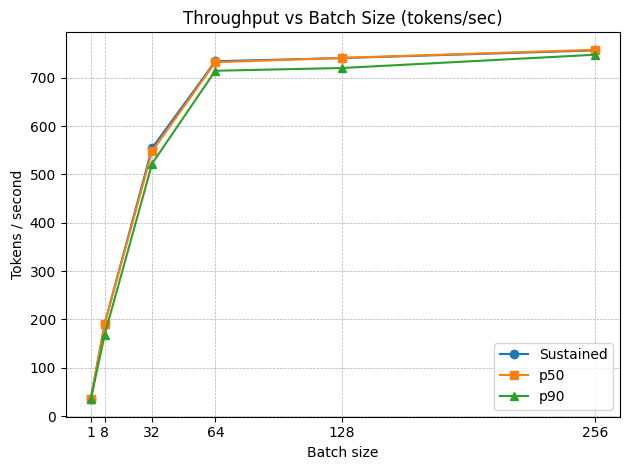

In [ ]:
x = df["batch_size"].tolist()

plot_lines(
    x,
    [
        (df["throughput_sustained_tok_s"], "Sustained", "o"),
        (df["throughput_p50_tok_s"],       "p50",       "s"),
        (df["throughput_p90_tok_s"],       "p90",       "^"),
    ],
    title="Throughput vs Batch Size (tokens/sec)",
    xlabel="Batch size",
    ylabel="Tokens / second",
    ylog=False,
    xticks=x
)

**Interpretation:** Throughput scales steeply with batch size up to around 64, after which it plateaus — indicating the GPU is fully saturated. Sustained, p50, and p90 values overlap closely, showing that throughput is stable and predictable.

#### Total latency vs batch size (p50, p90)

Illustrates how overall request latency grows as batch sizes increase, exposing potential bottlenecks.

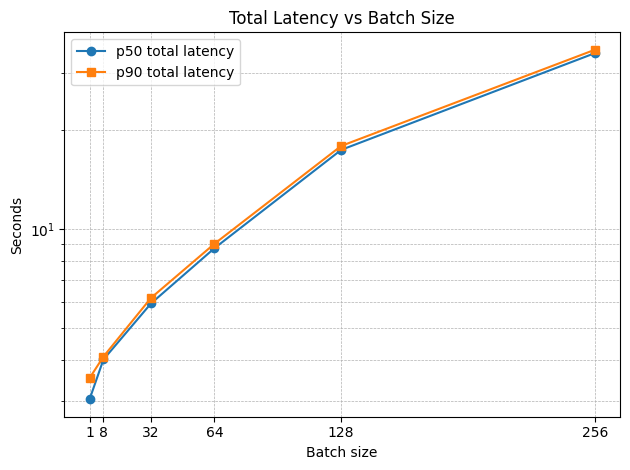

In [ ]:
x = df["batch_size"].tolist()

plot_lines(
    x,
    [
        (df["p50_latency_s"], "p50 total latency", "o"),
        (df["p90_latency_s"], "p90 total latency", "s"),
    ],
    title="Total Latency vs Batch Size",
    xlabel="Batch size",
    ylabel="Seconds",
    ylog=True,      # latencies can span orders of magnitude
    xticks=x
)

**Interpretation:** Total latency increases steadily with batch size — larger batches take significantly longer to complete, even though they improve throughput. The gap between p50 and p90 is very small, indicating stable performance across requests. This shows the trade-off: batching boosts capacity but comes at the cost of higher end-to-end wait times, which matters for user-facing workloads.

#### Time to First Token (TTFT) vs batch size (p50, p90)

Focuses on responsiveness by measuring how quickly the first token is produced under different batch loads.

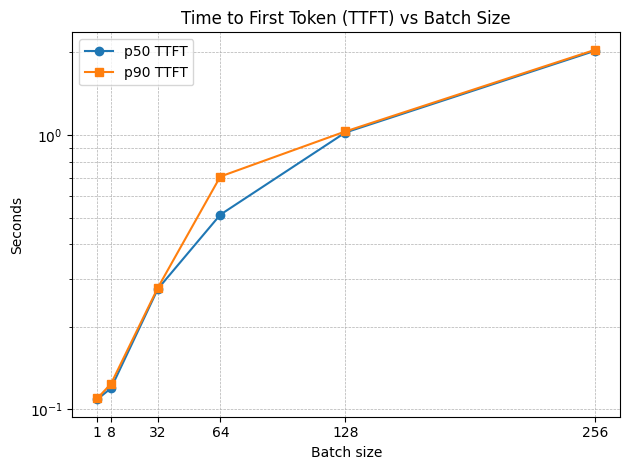

In [ ]:
x = df["batch_size"].tolist()

plot_lines(
    x,
    [
        (df["p50_ttft_s"], "p50 TTFT", "o"),
        (df["p90_ttft_s"], "p90 TTFT", "s"),
    ],
    title="Time to First Token (TTFT) vs Batch Size",
    xlabel="Batch size",
    ylabel="Seconds",
    ylog=True,
    xticks=x
)

**Interpretation:** Time to First Token (TTFT) grows steadily with batch size, meaning responsiveness degrades as more requests are batched together. While small batches deliver near-instant feedback (<1s), larger ones (128–256) push TTFT into several seconds. The tight overlap of p50 and p90 shows the effect is consistent across requests, underscoring the trade-off between batching for throughput and keeping the system interactive.

#### First-token vs total latency across batch sizes (p50, p90)

Compares initial responsiveness with full completion time, clarifying the trade-off between early feedback and overall latency.

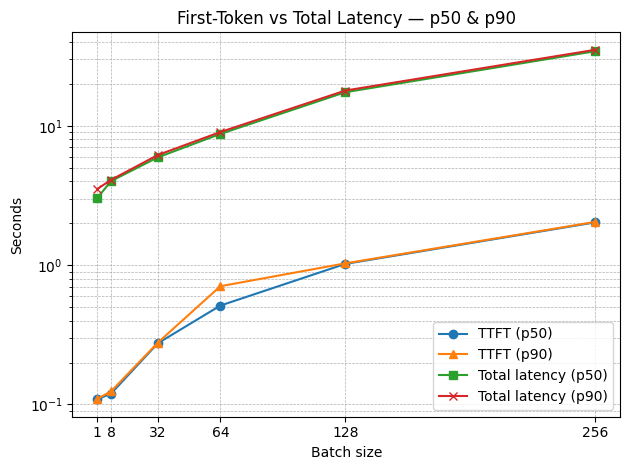

In [ ]:
# Sort & extract
x = df["batch_size"].tolist()

ttft_p50 = df["p50_ttft_s"].tolist()
ttft_p90 = df["p90_ttft_s"].tolist()
lat_p50  = df["p50_latency_s"].tolist()
lat_p90  = df["p90_latency_s"].tolist()

# Single figure with four series
plt.figure()
plt.plot(x, ttft_p50, marker="o", label="TTFT (p50)")
plt.plot(x, ttft_p90, marker="^", label="TTFT (p90)")
plt.plot(x, lat_p50,  marker="s", label="Total latency (p50)")
plt.plot(x, lat_p90,  marker="x", label="Total latency (p90)")

plt.title("First Token vs Total Latency — p50 & p90")
plt.xlabel("Batch size")
plt.ylabel("Seconds")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(x)
plt.yscale("log")  # latency scales fast with batch size; log makes it readable
plt.legend()
plt.tight_layout()
plt.show()

**Interpretation:** This chart shows how Time to First Token (TTFT) and total latency evolve together as batch size increases. TTFT remains much lower than total latency, meaning users see early feedback well before the full response finishes. However, both grow with larger batches, and the widening gap emphasizes the trade-off: batching improves throughput but stretches total completion times, while still preserving some interactivity through faster first token delivery.

#### Inter-Token Latency (ITL) vs batch size (p50, p90)

Looks at how long it takes to generate each additional token after the first, showing scaling behavior inside the decode loop.

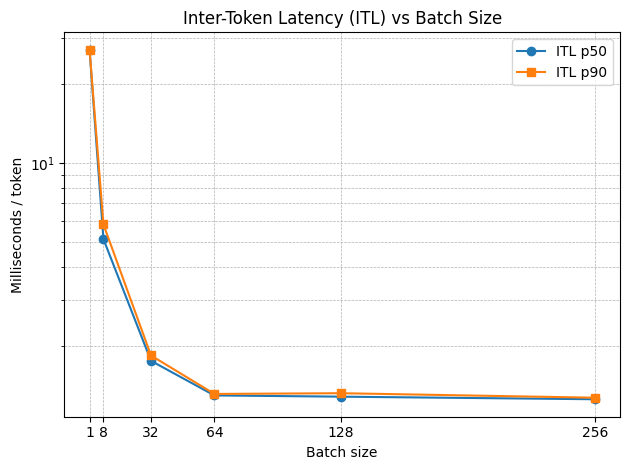

In [ ]:
x = df["batch_size"].tolist()

plot_lines(
    x,
    [
        (df["itl_p50_ms_per_tok"], "ITL p50", "o"),
        (df["itl_p90_ms_per_tok"], "ITL p90", "s"),
    ],
    title="Inter-Token Latency (ITL) vs Batch Size",
    xlabel="Batch size",
    ylabel="Milliseconds / token",
    ylog=True,
    xticks=x
)

**Interpretation:** Inter-Token Latency (ITL) drops sharply as batch size increases, stabilizing around 64 and beyond. This means once the first token is produced, subsequent tokens stream out much faster with larger batches.

#### Throughput vs latency trade-off (capacity vs responsiveness)

Highlights the fundamental trade-off: increasing batch size improves throughput but can hurt latency, affecting user experience.

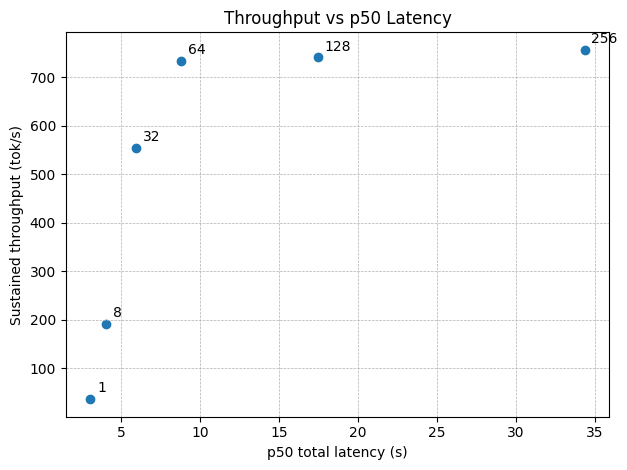

In [ ]:
import matplotlib.pyplot as plt

x = df["p50_latency_s"]
y = df["throughput_sustained_tok_s"]
labels = df["batch_size"].tolist()

plt.figure()
plt.scatter(x, y, marker="o")
for xi, yi, lbl in zip(x, y, labels):
    plt.annotate(str(lbl), (xi, yi), textcoords="offset points", xytext=(5,5))
plt.title("Throughput vs p50 Latency")
plt.xlabel("p50 total latency (s)")
plt.ylabel("Sustained throughput (tok/s)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

**Interpretation:** This chart highlights the throughput–latency trade-off. As batch size increases, throughput climbs sharply, but total latency also grows. The curve flattens beyond batch size 64, where throughput gains are small compared to the jump in latency.

#### Latency vs Throughput with knee point (p50 latency vs sustained throughput)

Identifies the “knee point” — the optimal balance where adding more requests no longer yields proportional throughput gains.

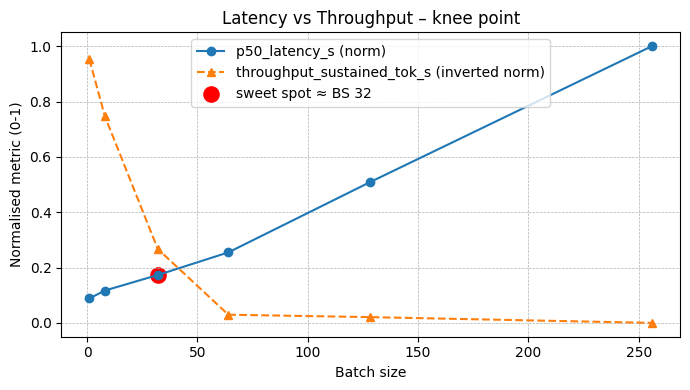

Knee ~ BS=32 | latency=5.947s | throughput=554.7 tok/s


In [ ]:
L_COL = "p50_latency_s"              # latency column
T_COL = "throughput_sustained_tok_s" # throughput column

needed = ["batch_size", L_COL, T_COL]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}. Re-run the benchmark with those fields.")

# Sort and extract arrays
df = df.sort_values("batch_size").reset_index(drop=True)
bs  = df["batch_size"].to_numpy(dtype=int)
lat = df[L_COL].to_numpy(dtype=float)
thr = df[T_COL].to_numpy(dtype=float)

# Normalize latency to [0,1]; normalize throughput and invert to [0,1]
lat_n   = lat / np.max(lat)                    # higher is worse
thr_inv = 1.0 - (thr / np.max(thr))            # invert so higher is worse

# Gap between the two normalized curves → knee where gap is smallest
gap    = np.abs(lat_n - thr_inv)
best_i = int(np.argmin(gap))

# Plot in your requested style
plt.figure(figsize=(7,4))
plt.plot(bs, lat_n,   'o-', label=f'{L_COL} (norm)')
plt.plot(bs, thr_inv, '^--', label=f'{T_COL} (inverted norm)')
plt.scatter(bs[best_i], lat_n[best_i], c='red', s=120,
            label=f'sweet spot ≈ BS {bs[best_i]}')
plt.xlabel("Batch size"); plt.ylabel("Normalised metric (0-1)")
plt.title("Latency vs Throughput – knee point")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(
    f"Knee ~ BS={bs[best_i]} | "
    f"latency={lat[best_i]:.3f}s | throughput={thr[best_i]:.1f} tok/s"
)

**Interpretation:** This plot visualizes the knee point where increasing batch size no longer delivers meaningful throughput gains relative to the rise in latency. The sweet spot appears around batch size 32 — beyond this, throughput plateaus while latency continues to climb. This point represents the best balance between system capacity and responsiveness for most practical workloads.

#### Finding the sweet spot based on UX budget

Choosing the optimal batch size isn’t just about throughput — it’s about respecting your users’ **latency expectations**.

This section helps you find the best-performing batch size that stays within a given **latency budget**, defined in seconds. You can adjust the value of `latency_budget` depending on your application’s needs (e.g. 2.5s for chat, 5s for summarization, etc.).

What this code does:

- Filters all benchmark results to include only configurations where latency is **below your target threshold**
- Then selects the **batch size with the highest throughput** from the remaining options
- Runs this selection twice:
  - Once using **p50 latency** (typical case)
  - Once using **p90 latency** (tail latency)

Try changing the `latency_budget` value and observe how the recommended batch size shifts depending on the metric used.

In [ ]:
latency_budget = 5  # seconds

filtered_p50 = df[df["p50_latency_s"] <= latency_budget]
filtered_p90 = df[df["p90_latency_s"] <= latency_budget]

if not filtered_p50.empty:
    best_row_p50 = filtered_p50.loc[filtered_p50["throughput_sustained_tok_s"].idxmax()]
    print(f"✅ Recommended: batch_size={int(best_row_p50.batch_size)}  "
          f"⇒  p50 latency = {best_row_p50.p50_latency_s:.2f}s, "
          f"throughput = {best_row_p50.throughput_sustained_tok_s:.0f} tok/s")
else:
    print(f"❌ No configuration meets the latency budget of {latency_budget:.1f}s")

if not filtered_p90.empty:
    best_row_p90 = filtered_p90.loc[filtered_p90["throughput_sustained_tok_s"].idxmax()]
    print(f"✅ Recommended: batch_size={int(best_row_p90.batch_size)}  "
          f"⇒  p90 latency = {best_row_p90.p90_latency_s:.2f}s, "
          f"throughput = {best_row_p90.throughput_sustained_tok_s:.0f} tok/s")
else:
    print(f"❌ No configuration meets the latency budget of {latency_budget:.1f}s based on p90 latency")

✅ Recommended: batch_size=8  ⇒  p50 latency = 4.02s, throughput = 191 tok/s
✅ Recommended: batch_size=8  ⇒  p90 latency = 4.10s, throughput = 191 tok/s


### Asessing impact of other parameters

So far, we’ve seen that **batch size** directly affects latency and throughput. But batch size isn’t the only factor that matters.

Let’s now explore how **other inference parameters**, starting with **output sequence length**, influence performance.

#### Sequence Length

The **sequence length** `max_tokens` parameter defines how many tokens the model is allowed to generate per prompt.

In practice:

- Short outputs (e.g. 32 tokens) return quickly
- Long outputs (e.g. 512 tokens) take significantly more time, especially at high batch sizes

This is because while **prefill cost is fixed**, the **decode phase scales linearly** with the number of tokens generated — we will look into that in future tutorials!

What this experiment does:

- Uses a fixed batch size (`batch = 32`)
- Varies the `max_tokens` cap from 32 to 256
- Measures **mean** and **p90 latency** across 20 runs for each setting

> Note: This experiment can take a few minutes — longer sequence lengths at high batch size are compute-intensive.

Let’s visualize how increasing the output length impacts both average latency and tail latency.

Processing with the sequence length =  32 ...
Processing with the sequence length =  64 ...
Processing with the sequence length = 128 ...
Processing with the sequence length = 256 ...


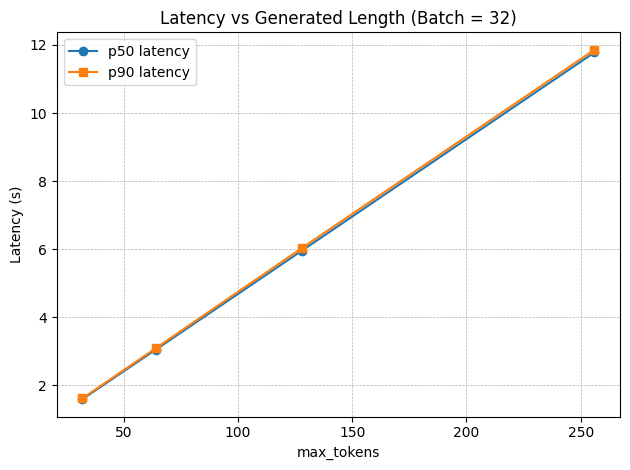

In [ ]:
# Latency vs Generated Length (p50 & p90) — batch fixed

import gc, numpy as np
import matplotlib.pyplot as plt
from vllm import SamplingParams

seq_lengths = [32, 64, 128, 256]
BATCH       = 32
RUNS        = 20   # effective samples per point (after warmup)
WARMUP      = 2

# Greedy sampling
GREEDY = dict(temperature=0.0, top_p=1.0)

lat_p50s, lat_p90s = [], []

for mt in seq_lengths:
    print(f"Processing with the sequence length = {mt:>3} ...")
    sp = SamplingParams(max_tokens=mt, **GREEDY)
    lats = []
    for r in range(RUNS + WARMUP):
        prompts = ["AI future is"] * BATCH
        t_total, _, _, _ = timed_generate(prompts, sp, as_chat=True, return_counts=True)
        if r < WARMUP:
            gc.collect(); torch.cuda.empty_cache()
            continue
        lats.append(t_total)
        gc.collect(); torch.cuda.empty_cache()

    # Percentiles on observed latencies (nearest-rank style)
    p50 = float(np.percentile(lats, 50, method="higher")) if lats else float("nan")
    p90 = float(np.percentile(lats, 90, method="higher")) if lats else float("nan")
    lat_p50s.append(p50)
    lat_p90s.append(p90)

plt.figure()
plt.plot(seq_lengths, lat_p50s, marker='o', label='p50 latency')
plt.plot(seq_lengths, lat_p90s, marker='s', label='p90 latency')
plt.xlabel('max_tokens'); plt.ylabel('Latency (s)'); plt.title('Latency vs Generated Length (Batch = 32)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(); plt.tight_layout(); plt.show()

**Interpretation:** Latency increases linearly with generated length, as expected in autoregressive decoding. This confirms that longer outputs scale predictably in cost, making latency primarily a function of sequence length rather than variability.

#### Sampling knobs (temperature & top-p) and determinism

You might be wondering — do **sampling parameters** like `temperature` and `top_p` affect latency? Let's check!

We run multiple generations using different combinations of:

- `temperature = [0.0, 0.7, 1.3]`
- `top_p     = [0.8, 0.9, 1.0]`

For each pair, we measure:

- **Mean latency**
- **p90 latency**

This helps us assess whether sampling diversity impacts performance.

Let’s visualize the results!

Running with T = 0.0 top_p = 0.8 ...
T=0.0 top_p=0.8 | p50 0.374s | p90 0.380s
Running with T = 0.0 top_p = 0.9 ...
T=0.0 top_p=0.9 | p50 0.375s | p90 0.376s
Running with T = 0.0 top_p = 1.0 ...
T=0.0 top_p=1.0 | p50 0.375s | p90 0.384s
Running with T = 0.7 top_p = 0.8 ...
T=0.7 top_p=0.8 | p50 0.387s | p90 0.388s
Running with T = 0.7 top_p = 0.9 ...
T=0.7 top_p=0.9 | p50 0.416s | p90 0.418s
Running with T = 0.7 top_p = 1.0 ...
T=0.7 top_p=1.0 | p50 0.405s | p90 0.409s
Running with T = 1.3 top_p = 0.8 ...
T=1.3 top_p=0.8 | p50 0.417s | p90 0.420s
Running with T = 1.3 top_p = 0.9 ...
T=1.3 top_p=0.9 | p50 0.418s | p90 0.421s
Running with T = 1.3 top_p = 1.0 ...
T=1.3 top_p=1.0 | p50 0.407s | p90 0.594s


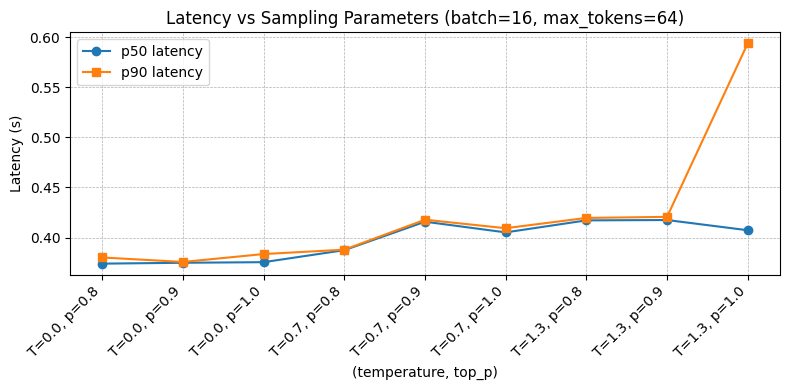

In [ ]:
# Latency vs Sampling Parameters — p50 & p90 (Nemotron Nano-9B-v2, reasoning OFF)

import gc, numpy as np, itertools, matplotlib.pyplot as plt
from vllm import SamplingParams

# ----- Grid to sweep -----
temps = [0.0, 0.7, 1.3]
tops  = [0.8, 0.9, 1.0]
grid  = list(itertools.product(temps, tops))

# ----- Benchmark knobs -----
BATCH        = 16          # run >1 to exercise scheduler
RUNS         = 20          # effective samples per point (after warmup)
WARMUP       = 2
MAX_TOKENS   = 64
SEED         = 1234        # set for reproducibility; set to None for true randomness

def pct(vals, p, method="higher"):
    """Nearest-rank-ish percentile using observed values."""
    arr = np.asarray(vals, float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return float("nan")
    return float(np.percentile(arr, p, method=method))

# ----- Results -----
lat_p50s, lat_p90s = [], []
labels = []

for t, p in grid:
    print(f"Running with T = {t:<3} top_p = {p:<3} ...")

    sp = SamplingParams(
        temperature=t,
        top_p=p,
        max_tokens=MAX_TOKENS
    )

    lats = []
    for r in range(RUNS + WARMUP):
        prompts = ["The capital of France is"] * BATCH
        t_total, _, _, _ = timed_generate(prompts, sp, as_chat=True, return_counts=True)
        if r < WARMUP:
            gc.collect(); import torch; torch.cuda.empty_cache()
            continue
        lats.append(t_total)
        gc.collect(); import torch; torch.cuda.empty_cache()

    p50 = pct(lats, 50)
    p90 = pct(lats, 90)
    lat_p50s.append(p50)
    lat_p90s.append(p90)
    labels.append(f"T={t}, p={p}")

    print(f"T={t:<3} top_p={p:<3} | p50 {p50:.3f}s | p90 {p90:.3f}s")

# ----- Visualization -----
x = range(len(grid))

plt.figure(figsize=(8, 4))
plt.plot(x, lat_p50s, marker='o', label='p50 latency')
plt.plot(x, lat_p90s, marker='s', label='p90 latency')
plt.xticks(x, labels, rotation=45, ha='right')
plt.xlabel('(temperature, top_p)')
plt.ylabel('Latency (s)')
plt.title(f'Latency vs Sampling Parameters (batch={BATCH}, max_tokens={MAX_TOKENS})')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**Interpretation:** Latency is largely unaffected by typical sampling parameter choices (temperature, top-p), remaining stable across most settings. Only at the extreme (high temperature with unrestricted top-p) does p90 latency spike, showing that aggressive randomness can introduce extra variability. This confirms that decoding strategies influence output quality more than raw performance, except in edge cases.

## Note on reasoning models

While this tutorial focuses on explaining LLM inference and its performance, it's important to recognize that not all language models are built the same.

Some are optimized for **throughput and deployment efficiency** (e.g. Mistral 7B, LLaMA 3 8B), while others are designed for **complex reasoning and instruction following** (e.g. GPT-4, Claude Opus, Gemini Pro, LLaMA 3 70B, NVIDIA Llama Nemotron).

When working with reasoning models, it's important to evaluate them not just on latency and throughput, but also on:

- Accuracy and depth of reasoning
- Consistency across temperature settings
- Ability to follow multi-step or long-form instructions

That said, **UX rules still apply**: a powerful model that takes 10 seconds to respond without streaming may still feel unusable, no matter how smart it is.

> In production, you'll often need to balance **speed** with **output quality** — especially for use cases involving multi-step reasoning or decision making.

👉 **Choose the model based on the application**: chat assistants, real-time agents, RAG pipelines, and batch summarization all have different performance vs. quality requirements.

The right tradeoff isn't about raw metrics — it's about delivering the right user experience for the task.

## Stop this notebook

Make sure to restart the jupyter kernel before proceeding with next exercises.

In [ ]:
import os
os._exit(0)